In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
from IPython.display import Audio, display
import os
import json
#import librosa
import warnings
from scipy.stats import entropy
warnings.filterwarnings("ignore")
%matplotlib inline
import sys
sys.path.append('../cdsd')
from data import CDSDDataset, get_data_transforms

In [2]:
classifier_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_crnn_classifier_frame'
separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen'
# classifier_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_crnn_classifier_clip'
# separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_clip_frozen'

In [3]:
classifier_train_history = os.path.join(classifier_dir, "history.csv")
separator_train_history = os.path.join(separator_dir, "history.csv")

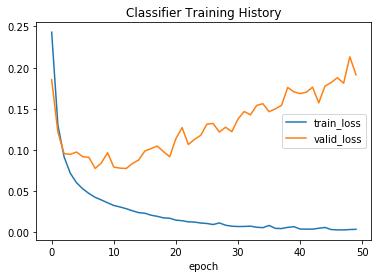

In [4]:
classifier_history = pd.read_csv(classifier_train_history)
classifier_history.plot(x='epoch', title='Classifier Training History')

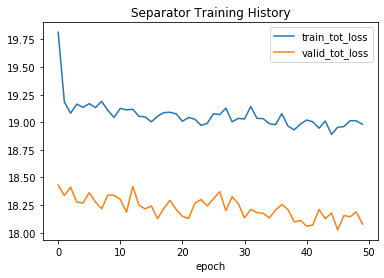

In [5]:
separator_history = pd.read_csv(separator_train_history)
separator_history.plot(x='epoch', y=['train_tot_loss', 'valid_tot_loss'], title='Separator Training History')

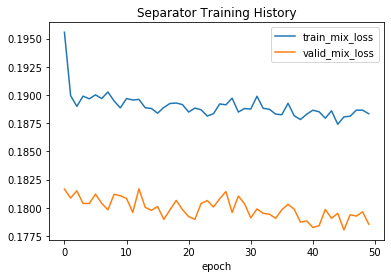

In [97]:
separator_history.plot(x='epoch', y=['train_mix_loss', 'valid_mix_loss'], title='Separator Training History')

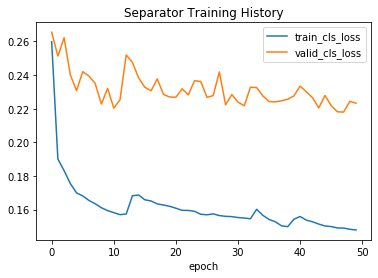

In [95]:
separator_history.plot(x='epoch', y=['train_cls_loss', 'valid_cls_loss'], title='Separator Training History')

In [6]:
sep_res_path = os.path.join(separator_dir, 'separation_results_test.csv')

In [7]:
sep_config_path = os.path.join(separator_dir, 'config.json')

In [8]:
with open(sep_config_path, 'r') as f:
    sep_config = json.load(f)

In [9]:
sep_config['root_data_dir']

'/beegfs/jtc440/cdsd-data/pishdadian2020-lambda5_soundscapes'

In [10]:
label_mode = sep_config['training']['label_mode']

In [11]:
sep_df = pd.read_csv(sep_res_path)

In [12]:
sep_df['dog_bark_sisdr_improvement'].median()

-70.29745101928711

In [13]:
sep_df.keys()

Index(['Unnamed: 0', 'filenames', 'car_horn_input_sisdr',
       'dog_bark_input_sisdr', 'gun_shot_input_sisdr',
       'jackhammer_input_sisdr', 'siren_input_sisdr',
       'car_horn_sisdr_improvement', 'dog_bark_sisdr_improvement',
       'gun_shot_sisdr_improvement', 'jackhammer_sisdr_improvement',
       'siren_sisdr_improvement', 'mixture_dbfs', 'isolated_car_horn_dbfs',
       'isolated_dog_bark_dbfs', 'isolated_gun_shot_dbfs',
       'isolated_jackhammer_dbfs', 'isolated_siren_dbfs',
       'reconstructed_car_horn_dbfs', 'reconstructed_dog_bark_dbfs',
       'reconstructed_gun_shot_dbfs', 'reconstructed_jackhammer_dbfs',
       'reconstructed_siren_dbfs', 'car_horn_presence_gt',
       'dog_bark_presence_gt', 'gun_shot_presence_gt',
       'jackhammer_presence_gt', 'siren_presence_gt',
       'car_horn_presence_frame_gt', 'dog_bark_presence_frame_gt',
       'gun_shot_presence_frame_gt', 'jackhammer_presence_frame_gt',
       'siren_presence_frame_gt', 'mixture_pred_car_horn',
 

In [14]:
labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]

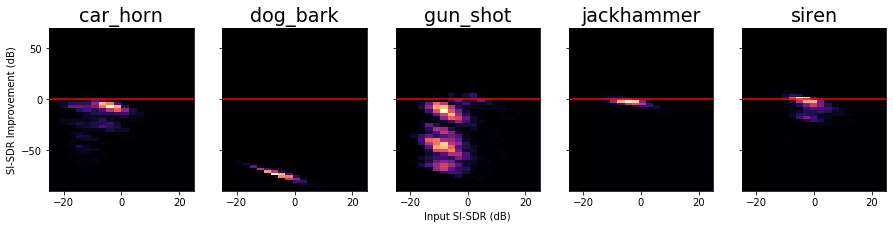

In [15]:
fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
plt.rcParams.update({'font.size': 16})
for idx, label in enumerate(labels):
    mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
    input_sisdr = sep_df[label + '_input_sisdr'].to_numpy()[mask]
    impro_sisdr = sep_df[label + '_sisdr_improvement'].to_numpy()[mask]

    ax = axes[idx]
    ax.set_title(label)
    if idx == 0:
        ax.set_ylabel('SI-SDR Improvement (dB)')
    if idx == (len(labels) // 2):
        ax.set_xlabel('Input SI-SDR (dB)')
    
    ax.hist2d(input_sisdr, impro_sisdr, bins=50, cmap='magma')
    ax.set_ylim([-90, 70])
    ax.set_xlim([-25, 25])
    ax.set_facecolor('black')
    ax.axhline(y=0, color='red')
    fig.patch.set_facecolor('white')
    

In [37]:
debug_train_masks.shape

(5, 1, 257, 501, 5)

In [58]:
input_transform = get_data_transforms(sep_config)   
train_dataset = CDSDDataset(sep_config['root_data_dir'],            
                            subset='train',           
                            transform=input_transform,
                            load_separation_data=True)
valid_dataset = CDSDDataset(sep_config['root_data_dir'],            
                            subset='valid',           
                            transform=input_transform,
                            load_separation_data=True)

In [82]:
mask_debug_path

'/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen/mask_debug_45.npz'

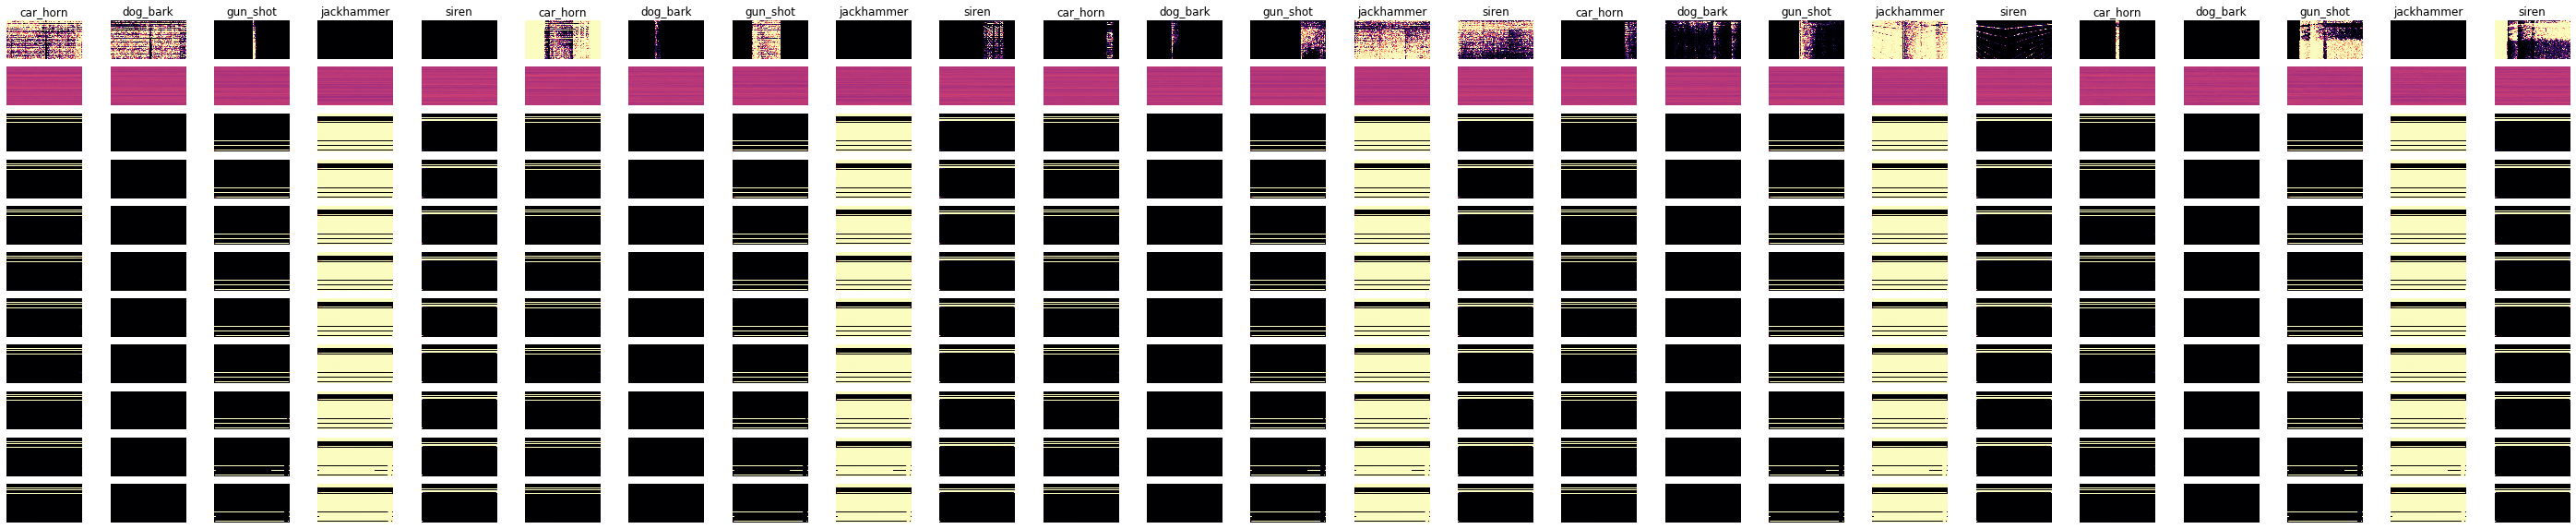

In [87]:
epoch_list = range(0, 50, 5)
mask_debug_path = os.path.join(separator_dir, 'mask_debug_0.npz')
mask_debug_data = np.load(mask_debug_path)
num_labels = len(labels)
num_debug_examples = mask_debug_data['train_idxs'].shape[0]


fig, axes = plt.subplots(nrows=len(epoch_list)+1, ncols=num_debug_examples*num_labels, figsize=(50,10), sharey=True)

for epoch_idx, debug_epoch in enumerate(epoch_list):
    mask_debug_path = os.path.join(separator_dir, 'mask_debug_{}.npz').format(debug_epoch)
    mask_debug_data = np.load(mask_debug_path)
    debug_train_masks = mask_debug_data['train_masks'].squeeze(axis=1)
    debug_train_idxs = mask_debug_data['train_idxs']
    debug_valid_masks = mask_debug_data['valid_masks'].squeeze(axis=1)
    debug_valid_idxs = mask_debug_data['valid_idxs']
    

    for label_idx, label in enumerate(labels):
        for idx in range(num_debug_examples):
            col_idx = idx * num_labels + label_idx
            ax = axes[epoch_idx+1, col_idx]
            ax.imshow(debug_train_masks[idx, ..., label_idx], cmap='magma', vmin=0, vmax=1)
            ax.axis('off')

            if col_idx == 0:
                ax.set_ylabel('Epoch\n{}'.format(debug_epoch), rotation=0)
    
for label_idx, label in enumerate(labels):
    for idx, ex_idx in enumerate(debug_train_idxs):
        col_idx = idx * num_labels + label_idx

        ex = train_dataset[ex_idx]
        mixture_spec = ex['audio_data'].squeeze()
        source_spec = ex[label + '_transformed'].squeeze()
        ideal_mask = np.nan_to_num(source_spec / mixture_spec)
        ax = axes[0, col_idx]
        ax.imshow(ideal_mask, cmap='magma', vmin=0, vmax=1)
        ax.axis('off')
        if col_idx == 0:
            ax.set_ylabel('Ideal\nRatio\nMask', rotation=0)
        ax.set_title(label)

        
#         ex = valid_dataset[ex_idx]
#         mixture_spec = ex['audio_data'].squeeze()
#         source_spec = ex[label + '_transformed'].squeeze()
#         ideal_mask = np.nan_to_num(source_spec / mixture_spec)


In [84]:

debug_train_masks[idx, ..., label_idx].max()

1.0

In [89]:
sep_config

{'input_transforms': [{'name': 'Spectrogram',
   'parameters': {'n_fft': 512,
    'hop_length': 128,
    'window_fn': 'sqrt_hann_window',
    'power': 1.0,
    'window_scaling': True}}],
 'separator': {'model': 'BLSTMSpectrogramSeparator',
  'input_transforms': [{'name': 'AmplitudeToDB',
    'parameters': {'stype': 'magnitude'}}],
  'parameters': {'n_bins': 257,
   'n_layers': 3,
   'hidden_dim': 600,
   'bias': True},
  'best_path': '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen/separator_best.pt',
  'latest_path': '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen/separator_latest.pt'},
 'classifier': {'model': 'CRNNSpectrogramClassifier',
  'parameters': {'n_bins': 257,
   'blstm_hidden_dim': 100,
   'conv_kernel_size': 5,
   'num_input_channels': 1,
   'bias': True,
   'pooling': None},
  'input_transforms': [{'name': 'AmplitudeToDB', 'parameters': {}}],
  'trainable': False,
  'pretrained_path': '/scratch/

In [19]:
y_gt = []
y_pred = []
y_pred_thresh = []
class_ap_score = {}
class_acc_score = {}

if label_mode == 'clip':
    for label in labels:
        y_gt_cls = np.array(sep_df[label + '_presence_gt'].to_list(), dtype=int)
        y_pred_cls = sep_df['mixture_pred_' + label].to_list()
        y_gt.append(y_gt_cls)
        y_pred.append(y_pred_cls)
        y_pred_cls_thresh = (np.array(y_pred_cls) >= 0.5).astype(int)
        class_acc_score[label] = (y_gt_cls == y_pred_cls_thresh).astype(float).mean()
        class_ap_score[label] = average_precision_score(y_gt_cls, y_pred_cls)
    y_gt = np.array(y_gt).T
    y_pred = np.array(y_pred).T
    y_pred_thresh = np.array(y_pred_thresh).T
else:
    for label in labels:
        y_gt_cls = np.array([eval(x) for x in sep_df[label + '_presence_frame_gt'].to_list()], dtype=int)
        y_pred_cls = [eval(x) for x in sep_df['mixture_pred_' + label].tolist()]
        y_gt.append(y_gt_cls)
        y_pred.append(y_pred_cls)
        y_pred_cls_thresh = (np.array(y_pred_cls) >= 0.5).astype(int)
        class_acc_score[label] = (y_gt_cls == y_pred_cls_thresh).astype(float).mean()
        class_ap_score[label] = average_precision_score(y_gt_cls, y_pred_cls)
    y_gt = np.array(y_gt).T
    y_pred = np.array(y_pred).T
    y_pred_thresh = np.array(y_pred_thresh).T
    

In [20]:
for label in labels:
    gt_key = label + "_presence_gt"
    print("{} clip-level ratio: {}".format(label, sep_df[gt_key].mean()))

car_horn clip-level ratio: 0.6402
dog_bark clip-level ratio: 0.6372
gun_shot clip-level ratio: 0.641
jackhammer clip-level ratio: 0.64
siren clip-level ratio: 0.635


In [21]:
cm = []
cooccurrence = []
thresholds = {label: 0.5 for label in labels}
for label_idx, label in enumerate(labels):
    pos_gt_idxs = y_gt[:, label_idx].nonzero()[0]
    cooccurrence.append(y_gt[pos_gt_idxs, :].mean(axis=0))
    
    fn_idxs = (y_pred[pos_gt_idxs, label_idx] < thresholds[label]).nonzero()[0]
    cm.append((y_pred[pos_gt_idxs, :][fn_idxs, :] > thresholds[label]).mean(axis=0))
cm = np.array(cm)
cooccurrence = np.array(cooccurrence)

In [ ]:
cm_min = cm[cm != 0].min()

plt.imshow(cm, aspect=1, cmap='magma', vmin=cm_min * 0.8, vmax=1)
plt.colorbar()
plt.ylabel('Ground truth class\n(Predicted as negative)')
plt.xlabel('Predicted positive classes')
plt.title('Class confusion')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

In [ ]:
plt.imshow(cooccurrence, aspect=1, cmap='magma', vmin=0, vmax=1)
plt.colorbar()
plt.title('Class co-occurrence')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

Text(0.5, 1.1, 'Model activation distributions')

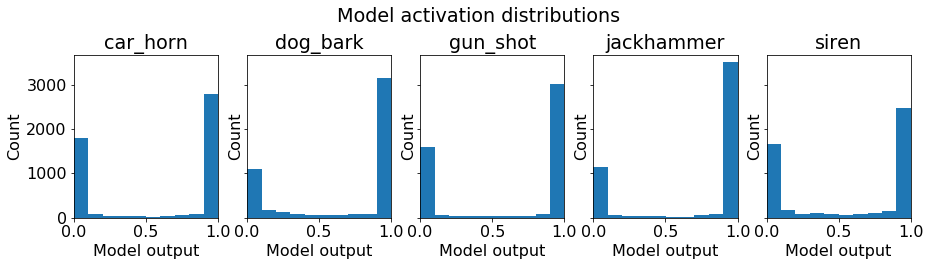

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 3), sharey=True)
for idx, (label, y) in enumerate(zip(labels, y_pred.T)):
    ax = axes[idx]
    ax.hist(y)
    ax.set_title(label)
    ax.set_ylabel('Count')
    ax.set_xlabel('Model output')
    ax.set_xlim([0, 1.0])
    #plt.yscale('log')
fig.suptitle("Model activation distributions", y = 1.1)

In [24]:
class_acc_score

{'car_horn': 0.9563696,
 'dog_bark': 0.9043456,
 'gun_shot': 0.9036064,
 'jackhammer': 0.9178112,
 'siren': 0.9089072}

In [27]:
#average_precision_score(y_gt, y_pred, average='macro')

In [26]:
class_ap_score

{'car_horn': 0.9939091414008566,
 'dog_bark': 0.9731553430661394,
 'gun_shot': 0.9363888037188528,
 'jackhammer': 0.9913587396330666,
 'siren': 0.9861890933447094}

In [13]:
recon_dir = os.path.join(separator_dir, "reconstructed_audio")

In [46]:
target_label = "dog_bark"
ex_idx = 120

In [47]:
pos_filenames = sep_df[sep_df[target_label + "_presence_gt"] == 1]["filenames"].tolist()
fname = pos_filenames[ex_idx]
audio_path = os.path.join(recon_dir, "{}_{}_recon.mp3".format(fname, target_label))
display(Audio(filename=audio_path))
sep_df[sep_df["filenames"]==fname][[x + "_presence_gt" for x in labels]]

,car_horn_presence_gt,dog_bark_presence_gt,gun_shot_presence_gt,jackhammer_presence_gt,siren_presence_gt
194,1.0,1.0,1.0,1.0,0.0


In [49]:
label_rms_lists = {}
for label in labels:
    pos_filenames = sep_df[sep_df[label + "_presence_gt"] == 1]["filenames"].tolist()
    rms_list = []
    for fname in pos_filenames:
        audio_path = os.path.join(recon_dir, "{}_{}_recon.mp3".format(fname, target_label))
        audio, sr = librosa.load(audio_path, sr=None)
        rms = np.sqrt(np.mean(audio.flatten() ** 2))
        rms_list.append(rms)
    label_rms_lists[label] = rms_list

In [ ]:
rms_max = 0.0
for rms_list in label_rms_lists.values():
    rms_max = max(np.max(rms_list), rms_max)

In [ ]:
rms_max

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 3), sharey=True)
for idx, (label, rms_list) in enumerate(label_rms_lists.items()):
    ax = axes[idx]
    ax.hist(rms_list)
    ax.set_title(label)
    if idx == 0:
        ax.set_ylabel('Count')
    if idx == (len(labels) // 2):
        ax.set_xlabel('RMS')
    ax.set_xlim([0, rms_max * 1.1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #plt.yscale('log')
fig.suptitle("RMS distributions", y = 1.1)